In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report


# Readings Data
  📘 Reading the dataset file (train.csv) using pandas library and displaying the first 5 rows

In [21]:

train_path = r"C:\Users\sondos\Desktop\csc\archive\train.csv"

train_df = pd.read_csv(train_path)

print(train_df.head())



   battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   

   mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2  ...         20       756  2549     9     7         19   
1        136        3  ...        905      1988  2631    17     3          7   
2        145        5  ...       1263      1716  2603    11     2          9   
3        131        6  ...       1216      1786  2769    16     8         11   
4        141        2  ...       1208      1212  1411     8     2         15   

   three_g  touch_screen  wifi  price_

* 📊 Display general information about the dataset such as number of rows, columns, data types, and missing values

In [8]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [9]:
# Display descriptive statistics of the dataset such as mean, standard deviation, min, and max values
print(train_df.describe())

       battery_power       blue  clock_speed     dual_sim           fc  \
count    2000.000000  2000.0000  2000.000000  2000.000000  2000.000000   
mean     1238.518500     0.4950     1.522250     0.509500     4.309500   
std       439.418206     0.5001     0.816004     0.500035     4.341444   
min       501.000000     0.0000     0.500000     0.000000     0.000000   
25%       851.750000     0.0000     0.700000     0.000000     1.000000   
50%      1226.000000     0.0000     1.500000     1.000000     3.000000   
75%      1615.250000     1.0000     2.200000     1.000000     7.000000   
max      1998.000000     1.0000     3.000000     1.000000    19.000000   

            four_g   int_memory        m_dep    mobile_wt      n_cores  ...  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000  ...   
mean      0.521500    32.046500     0.501750   140.249000     4.520500  ...   
std       0.499662    18.145715     0.288416    35.399655     2.287837  ...   
min       0.00000

In [10]:
#  Check for missing (null) values in each column of the dataset
train_df.isnull().sum() 

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

# Outliers

*  This code uses matplotlib and seaborn to draw Boxplots for all numeric columns in the dataset.
 * Each plot shows the relationship between a numeric feature (like ram or battery_power) and the price range category.
 * It helps to understand how different feature values affect the price range
 * and to detect any patterns or outliers in the data.

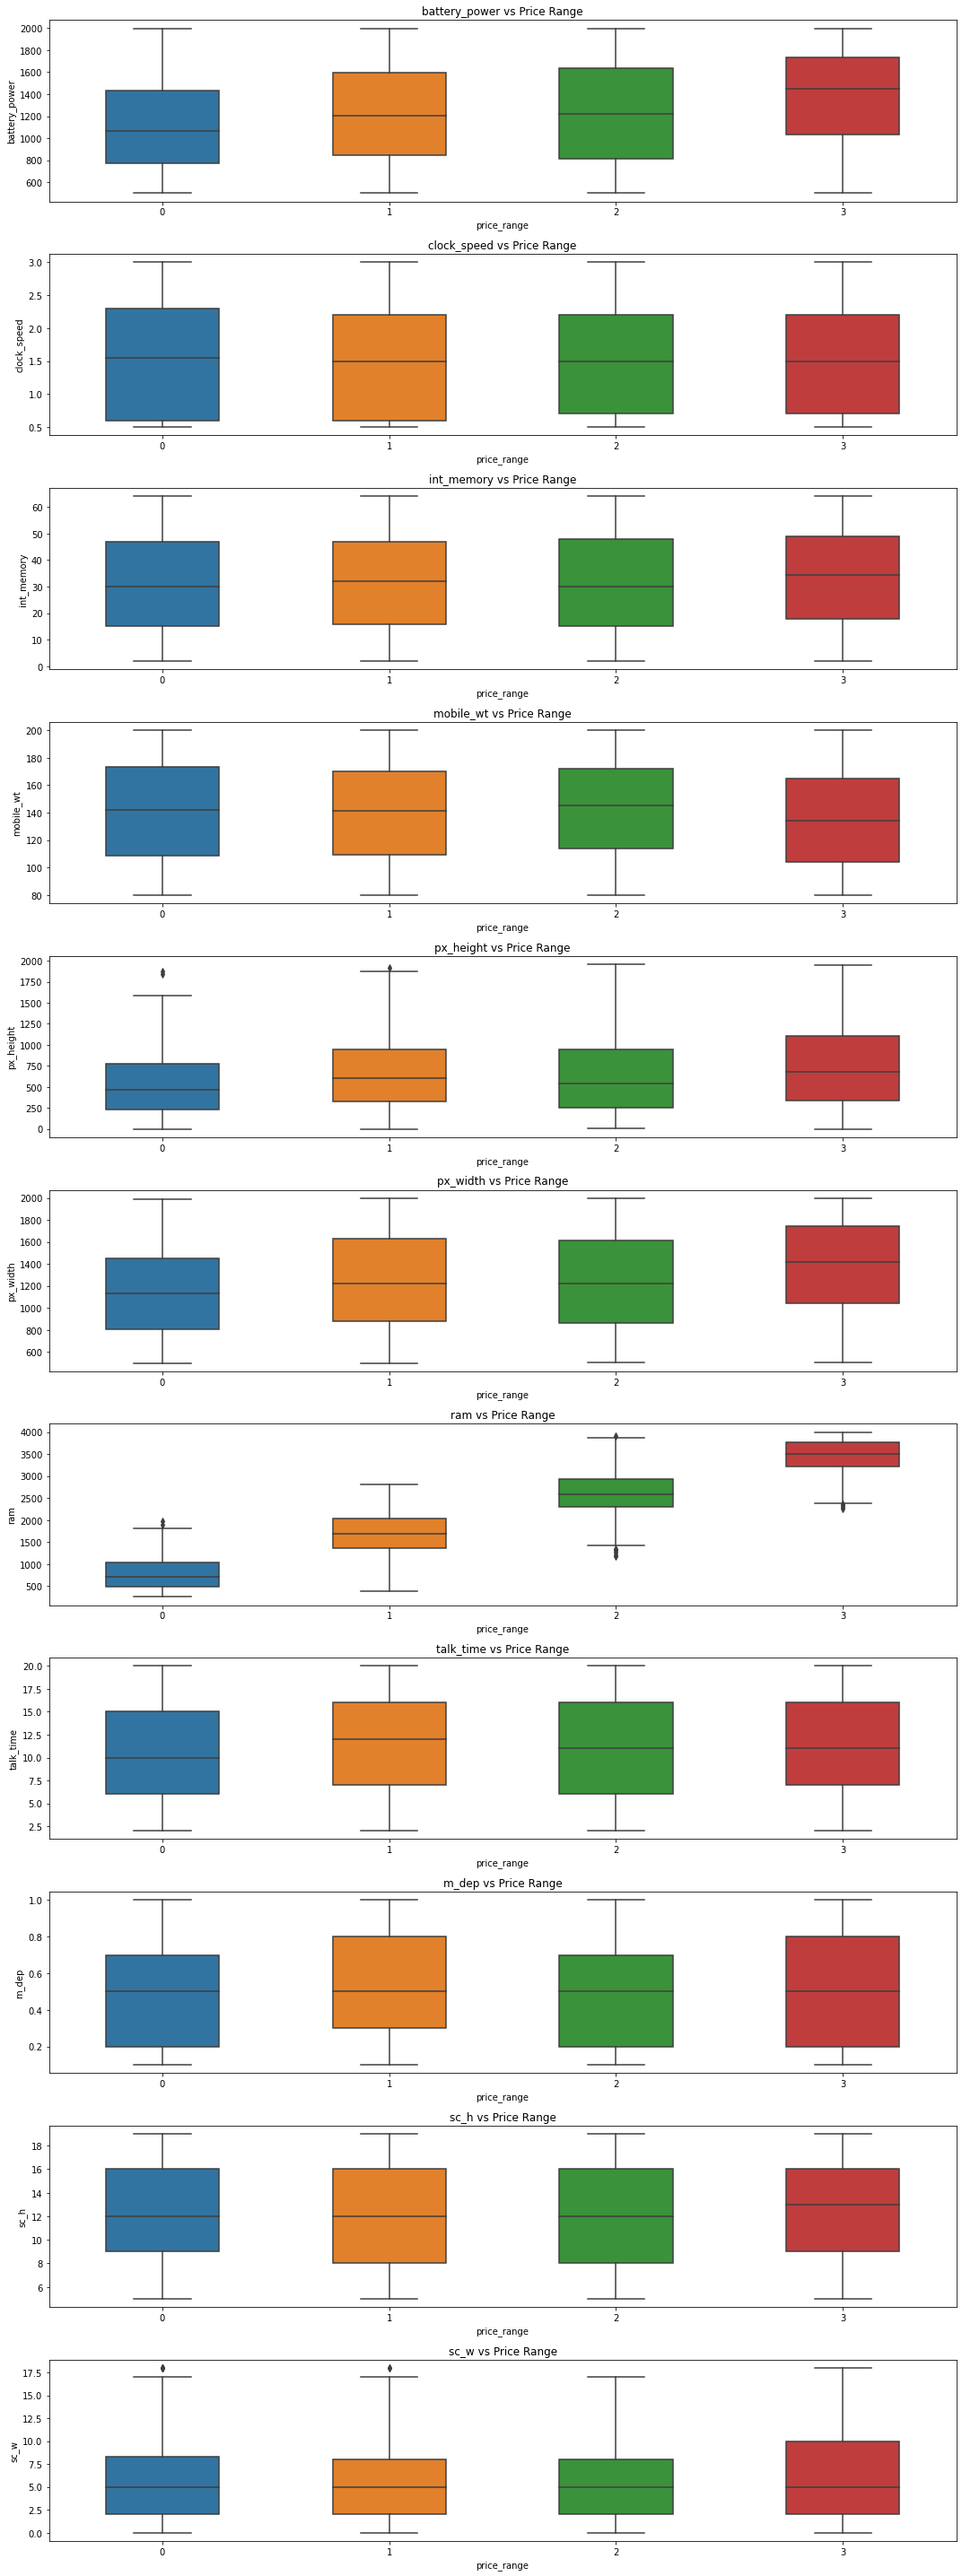

In [11]:

numeric_cols = ['battery_power', 'clock_speed', 'int_memory', 'mobile_wt', 
                'px_height', 'px_width', 'ram', 'talk_time', 'm_dep', 'sc_h', 'sc_w']

plt.figure(figsize=(15, 40))
for i, col in enumerate(numeric_cols):
    plt.subplot(len(numeric_cols), 1, i+1)
    sns.boxplot(x='price_range', y=col, data=train_df, width=0.5)  
    plt.title(f'{col} vs Price Range')
plt.tight_layout()
plt.show()


# DROP OUTLIER
*   This code detects and removes outliers in the selected columns ['px_height', 'ram', 'sc_w'] using the IQR method.
  * First, it prints the original number of rows in the dataset.
  * Then, it calculates the first quartile (Q1), third quartile (Q3), and the interquartile range (IQR).
  * Next, it creates a new cleaned dataset (df_clean) without rows containing outliers in the selected columns.
  * It prints the number of rows after removing outliers.
  * Finally, it plots Boxplots for each column before and after removing outliers,
  * allowing us to visually see the difference and understand the effect of cleaning.


In [12]:
cols_to_check = ['px_height', 'ram', 'sc_w']

Q1 = train_df[cols_to_check].quantile(0.25)
Q3 = train_df[cols_to_check].quantile(0.75)
IQR = Q3 - Q1

df_clean = train_df[~((train_df[cols_to_check] < (Q1 - 1.5 * IQR)) | 
                      (train_df[cols_to_check] > (Q3 + 1.5 * IQR))).any(axis=1)]


عدد الصفوف الأصلي: 2000
عدد الصفوف بعد حذف القيم الشاذة: 1998


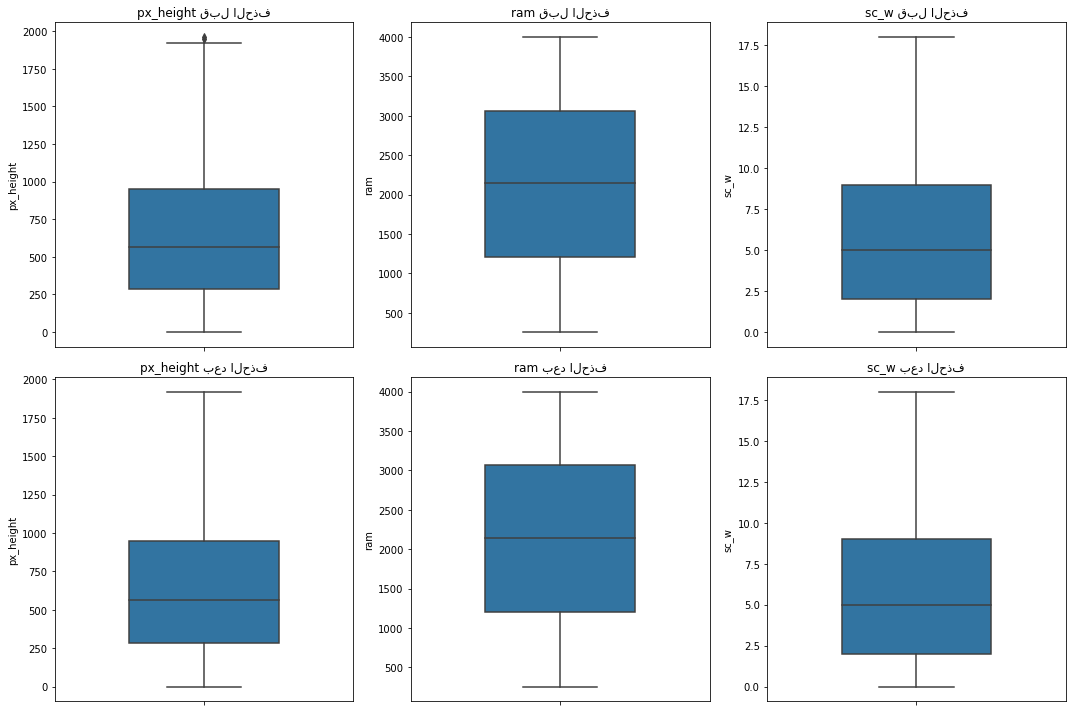

In [13]:

cols_to_check = ['px_height', 'ram', 'sc_w']

print("عدد الصفوف الأصلي:", train_df.shape[0])


Q1 = train_df[cols_to_check].quantile(0.25)
Q3 = train_df[cols_to_check].quantile(0.75)
IQR = Q3 - Q1


df_clean = train_df[~((train_df[cols_to_check] < (Q1 - 1.5 * IQR)) | 
                      (train_df[cols_to_check] > (Q3 + 1.5 * IQR))).any(axis=1)]

print("عدد الصفوف بعد حذف القيم الشاذة:", df_clean.shape[0])

plt.figure(figsize=(15, 10))

for i, col in enumerate(cols_to_check):
    plt.subplot(2, len(cols_to_check), i+1)
    sns.boxplot(y=train_df[col], width=0.5)
    plt.title(f'{col} قبل الحذف')

    plt.subplot(2, len(cols_to_check), i+1+len(cols_to_check))
    sns.boxplot(y=df_clean[col], width=0.5)
    plt.title(f'{col} بعد الحذف')

plt.tight_layout()
plt.show()


# matplotlib
*  This code plots Histograms for all numeric columns in the dataset.
* It helps to visualize the distribution of values for each column
* and understand the shape of the data (symmetric, skewed, or clustered in certain values).

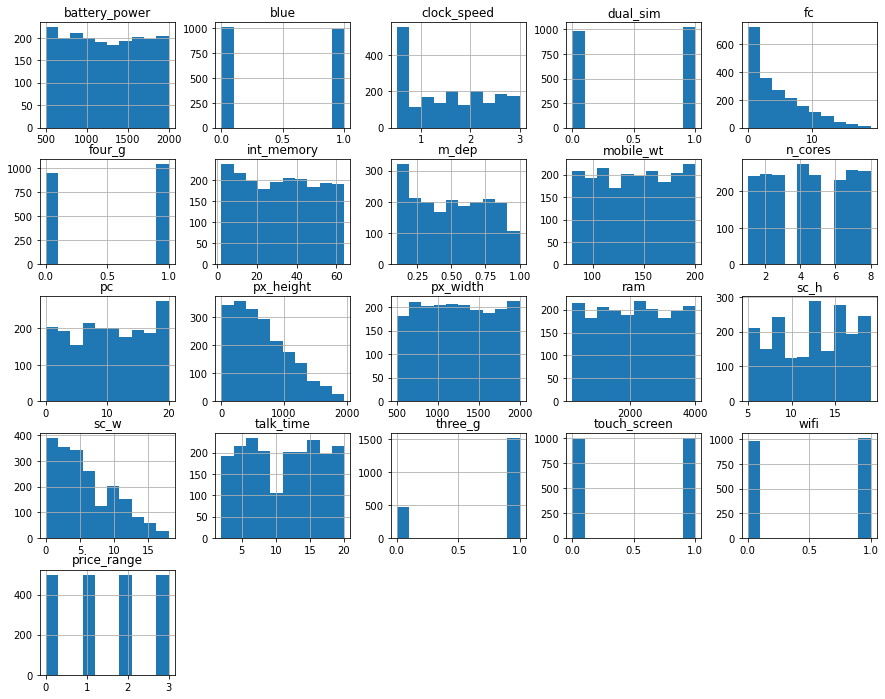

In [14]:


# رسم histogram لكل عمود عددي
numeric_cols = train_df.select_dtypes(include=['int64','float64']).columns
train_df[numeric_cols].hist(figsize=(15,12))
plt.show()


#  This code plots a heatmap of correlations between all numeric columns in the dataset.
   *   Each cell shows the strength and direction of the relationship between two columns (values between -1 and 1).
   * This helps to identify which features are strongly related to each other, especially with the target variable (like   price_range).

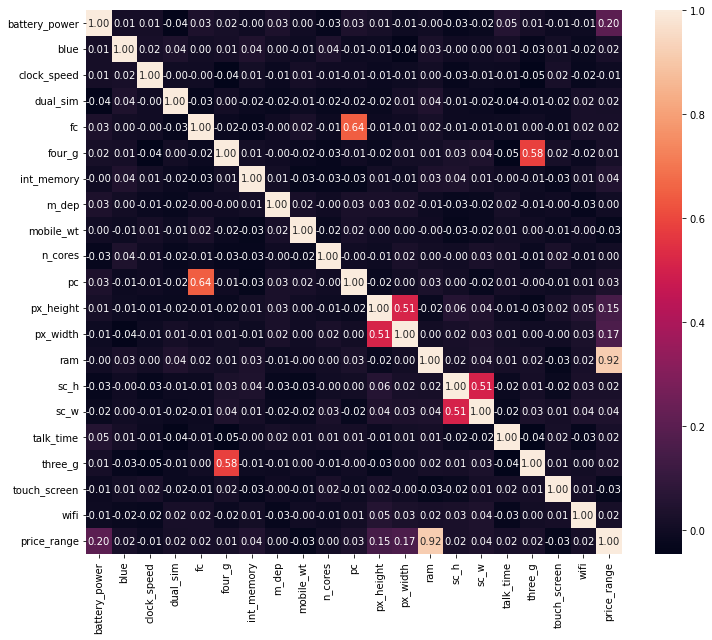

In [15]:
plt.figure(figsize=(12,10))
sns.heatmap(train_df.corr(), annot=True, fmt=".2f")
plt.show()


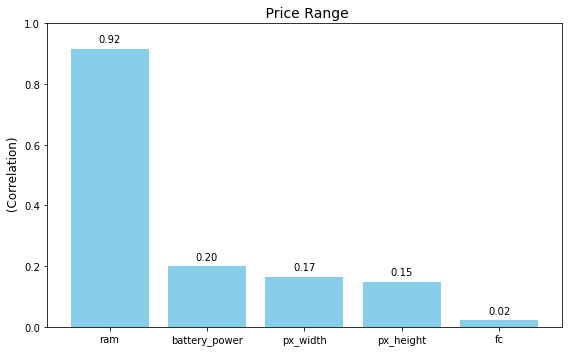

In [28]:

# قراءة البيانات
train_path = r"C:\Users\sondos\Desktop\csc\archive\train.csv"
train_df = pd.read_csv(train_path)

important_features = ['ram', 'fc', 'px_width', 'px_height', 'battery_power']
target = 'price_range'

# حساب correlation بين الأعمدة المهمة والهدف
correlations = train_df[important_features + [target]].corr()[target].drop(target)

# ترتيب الأعمدة حسب قوة العلاقة
correlations = correlations.abs().sort_values(ascending=False)

# رسم bar chart
plt.figure(figsize=(8,5))
bars = plt.bar(correlations.index, correlations.values, color='skyblue')
plt.title(' Price Range', fontsize=14)
plt.ylabel(' (Correlation)', fontsize=12)
plt.ylim(0,1)

# إضافة القيم على الأعمدة
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


#  📘Read the test dataset file (test.csv) using the pandas library

In [16]:

test_df  = pd.read_csv(r"C:\Users\sondos\Desktop\csc\archive\test.csv")


# Machine Learning

* 1️⃣ Read the datasets: train.csv for training and test.csv for testing
* 2️⃣ Feature Engineering: create new features to help the model predict better:
*    - screen_area : screen height * width
*    - total_memory : RAM + internal memory
*    - pixel_density : sqrt(px_height^2 + px_width^2)
*    - ram_battery_ratio : ratio of RAM to battery power
* 3️⃣ Define important features and target column
* 4️⃣ Scaling: normalize values using StandardScaler for better model performance
* 5️⃣ Split the data: 80% train, 20% validation with stratify to maintain class distribution
* 6️⃣ Build an XGBoost classifier with tuned hyperparameters to improve accuracy
* 7️⃣ Evaluate the model on the validation set using Accuracy, F1 Score, Precision, Recall, and Classification Report
* 8️⃣ Predict on the test set (X_test_scaled)

In [27]:


train_df = pd.read_csv(r"C:\Users\sondos\Desktop\csc\archive\train.csv")  
test_df  = pd.read_csv(r"C:\Users\sondos\Desktop\csc\archive\test.csv")  

# ===== 2️⃣ Feature Engineering =====
train_df['screen_area'] = train_df['px_height'] * train_df['px_width']
test_df['screen_area']  = test_df['px_height'] * test_df['px_width']

train_df['total_memory'] = train_df['ram'] + train_df['int_memory']
test_df['total_memory']  = test_df['ram'] + test_df['int_memory']

train_df['pixel_density'] = ((train_df['px_height']**2 + train_df['px_width']**2)**0.5)
test_df['pixel_density']  = ((test_df['px_height']**2 + test_df['px_width']**2)**0.5)

train_df['ram_battery_ratio'] = train_df['ram'] / train_df['battery_power']
test_df['ram_battery_ratio']  = test_df['ram'] / test_df['battery_power']

# ===== 3️⃣ تحديد الميزات والهدف =====
important_features = [
    'ram', 'fc', 'px_width', 'px_height', 'battery_power',
    'int_memory', 'screen_area', 'total_memory',
    'pixel_density', 'ram_battery_ratio'
]
target = 'price_range'

X = train_df[important_features]
y = train_df[target]
X_test = test_df[important_features]

# ===== 4️⃣ Scaling =====
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# ===== 5️⃣ تقسيم البيانات =====
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# ===== 6️⃣  XGBoost  =====
xgb_model = xgb.XGBClassifier(
    n_estimators=1200,
    max_depth=8,
    learning_rate=0.02,
    subsample=0.85,
    colsample_bytree=0.85,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

xgb_model.fit(X_train, y_train)

# =====   Validation =====
y_val_pred = xgb_model.predict(X_val)

print("✅ Accuracy:", accuracy_score(y_val, y_val_pred))
print("✅ F1 Score:", f1_score(y_val, y_val_pred, average='weighted'))
print("✅ Precision:", precision_score(y_val, y_val_pred, average='weighted'))
print("✅ Recall:", recall_score(y_val, y_val_pred, average='weighted'))
print("\n✅ Classification Report:\n", classification_report(y_val, y_val_pred))

# =====  Test =====
y_test_pred = xgb_model.predict(X_test_scaled)


C:\Users\sondos\OneDrive\anconda2\lib\site-packages\xgboost\core.py:158: UserWarning: [12:01:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy: 0.9525
✅ F1 Score: 0.9523330533337273
✅ Precision: 0.9527799095692648
✅ Recall: 0.9525

✅ Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       0.97      0.91      0.94       100
           2       0.91      0.93      0.92       100
           3       0.96      0.97      0.97       100

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400



 * Predict on the Validation set using the trained model
 y_val_pred contains the predicted values for each row in the validation set

 * Calculate key evaluation metrics
 Accuracy: proportion of correct predictions out of total samples
 F1 Score: combination of Precision and Recall giving overall performance per class
 Precision: proportion of correct predictions per class out of all predictions for that class
 Recall: proportion of correct predictions per class out of all true samples of that class

 * Print a detailed Classification Report for each class
 Includes Precision, Recall, F1-Score, and Support for each class


# pkl

* Saving the trained model and scaler for later use without retraining
* pickle allows storing any Python object to a file that can be loaded later

* Saving the XGBoost model to 'xgb_model.pkl'
* Saving the StandardScaler used for scaling features to 'scaler_xgb.pkl'

In [29]:
import pickle
import xgboost as xgb
from sklearn.preprocessing import StandardScaler



with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)


with open('scaler_xgb.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("✅ تم حفظ النموذج وScaler بنجاح!")


✅ تم حفظ النموذج وScaler بنجاح!


# django

In [24]:
!pip install django


   ---------------------------------------- 8.0/8.0 MB 4.3 MB/s  0:00:02



In [3]:
pip install torch torchvision pandas scikit-learn matplotlib


Note: you may need to restart the kernel to use updated packages.
